In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import statsmodels.api as sm
from os import listdir
from os.path import isfile, join
from scipy import stats
from skimage import io

import sys
sys.path.append('..')
import src as tools

COLOR_MAP = {
    "light_orange": "#E69F00",
    "light_blue": "#56B4E9",
    "teal": "#009E73",
    "yellow": "#F0E442",
    "dark_blue": "#0072B2",
    "dark_orange": "#D55E00",
    "pink": "#CC79A7",
    "purple": "#9370DB",
    "black": "#000000",
    "silver": "#DCDCDC",
}

## Prepare Data 

Load 2019 and 2020 data. Drop calls with duration longer than 120 minutes.

In [2]:
df = pd.read_csv("../data/df_for_response_time_modeling.csv", index_col = 0)

df["date"] =pd.to_datetime(df["date"])
df["call_datetime"] =pd.to_datetime(df["call_datetime"])
df["disp_datetime"] =pd.to_datetime(df["disp_datetime"])
df["clrd_datetime"] =pd.to_datetime(df["clrd_datetime"])


df["response_time_minutes"] = [math.ceil(t) for t in df["response_time_minutes"]]
df = df[df["response_time_minutes"] <=120].copy()
df = df[df["call_type"] != "Initiated"].copy()
df.reset_index(drop = True, inplace = True)

df.head()

,date,change_idx,log_num,pdf_page,call_datetime,call_reason,call_type,call_action,call_taker,street,call_category,responding_units,disp_datetime,clrd_datetime,response_time_minutes,hour,weekday,month
0,2019-01-01,289,19-13,3,2019-01-01 11:22:00,ROAD CONDITIONS,911,REMOVED HAZARD,2,148,Rapid Response,1.0,2019-01-01 11:24:04,2019-01-01 11:31:31,10,11,1,1
1,2019-01-01,579,19-22a,4,2019-01-01 15:27:00,MOTOR VEHICLE ACCIDENT,911,BUILDING CHECKED/SECURED,11,164,Rapid Response,4.0,2019-01-01 15:27:00,2019-01-01 15:44:26,18,15,1,1
2,2019-01-01,579,19-22b,4,2019-01-01 15:27:00,MOTOR VEHICLE ACCIDENT,911,BUILDING CHECKED/SECURED,11,164,Rapid Response,7.0,2019-01-01 15:27:00,2019-01-01 15:46:09,20,15,1,1
3,2019-01-02,1370,19-42,6,2019-01-02 06:44:00,NOISE COMPLAINT,Phone,SERVICES RENDERED,6,104,Nonemergency Service,8.0,2019-01-02 06:47:25,2019-01-02 06:57:29,14,6,2,1
4,2019-01-02,1858,19-56,8,2019-01-02 10:00:00,PARKING CHECK,Phone,PATROL ADVISED,15,29,Nonemergency Service,1.0,2019-01-02 10:00:00,2019-01-02 10:01:04,2,10,2,1


#### Data Transformation for Learning Pipeline

Fit time variables to cyclic splines, get one-hot for categorical and scale data.

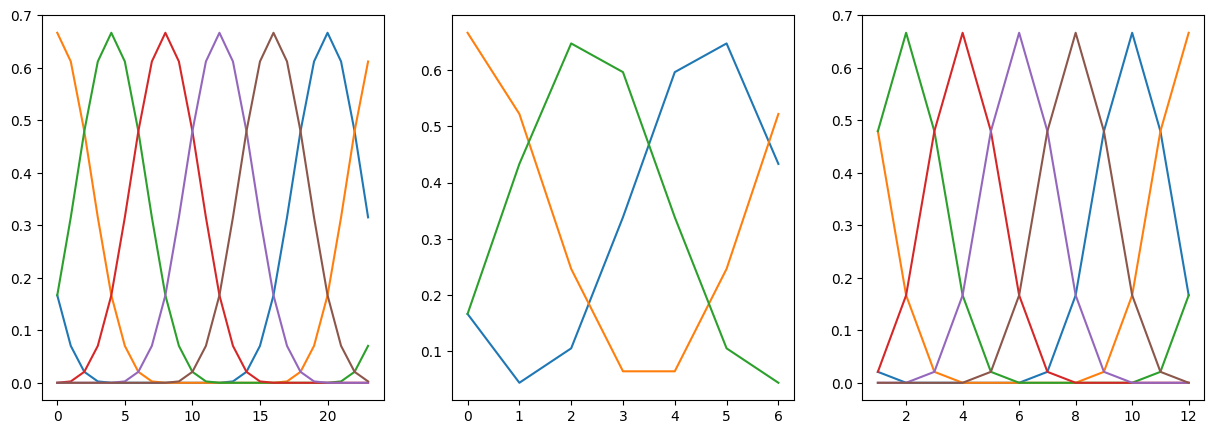

In [3]:
from sklearn.preprocessing import SplineTransformer
from sklearn.preprocessing import StandardScaler

def get_spline(degree, period, n_splines, df, feat):
    values = df[feat].values.reshape(-1,1)
    n_knots = n_splines + 1

    spline = SplineTransformer(degree=degree,
                             n_knots=n_knots, 
                             knots = np.linspace(0,period, n_knots).reshape(n_knots,1),
                             extrapolation = "periodic",
                             include_bias = True)
    spline_feat = spline.fit_transform(values)
    df_spline = pd.DataFrame(spline_feat, 
                             columns = [f"{feat}_cyclic_{i}" for i in range(spline_feat.shape[1])])
    
    return df_spline

fig, ax = plt.subplots(1,3, figsize = (15,5))

hr_spline = get_spline(degree = 3,
                       period = 24, 
                       n_splines = 6, 
                       df = df,
                       feat = "hour")

wk_spline = get_spline(degree = 3,
                       period = 7, 
                       n_splines = 3,
                       df = df,
                       feat = "weekday")

mo_spline = get_spline(degree = 3,
                       period = 12, 
                       n_splines = 6,
                       df = df,
                       feat = "month")

for i in range(hr_spline.shape[1]):
    idx = df["hour"].sort_values().index
    ax[0].plot(df["hour"].sort_values(),hr_spline.iloc[idx,i])
    
for i in range(wk_spline.shape[1]):
    idx = df["weekday"].sort_values().index
    ax[1].plot(df["weekday"].sort_values(),wk_spline.iloc[idx,i])
    
for i in range(mo_spline.shape[1]):
    idx = df["month"].sort_values().index
    ax[2].plot(df["month"].sort_values(),mo_spline.iloc[idx,i])
    


In [4]:
def prepare_data(df, categorical_feat, degree = 3, hr_splines = 12, wk_splines = 3, mo_splines = 6):
    
    # Get cyclic splines
    hr_spline = get_spline(degree = degree,
                       period = 24, 
                       n_splines = hr_splines, 
                       df = df,
                       feat = "hour")

    wk_spline = get_spline(degree = 3,
                           period = 7, 
                           n_splines = wk_splines,
                           df = df,
                           feat = "weekday")

    mo_spline = get_spline(degree = 3,
                           period = 12, 
                           n_splines = mo_splines,
                           df = df,
                           feat = "month")
    
    if len(categorical_feat) > 0:
        df[categorical_feat] = df[categorical_feat].astype(str)
        df_categorical = pd.get_dummies(df[categorical_feat])
    
        # Get one-hot categorical
        data = pd.concat([df_categorical,hr_spline, wk_spline, mo_spline], axis = 1)
    
    else:
        data = pd.concat([hr_spline, wk_spline, mo_spline], axis = 1)

    # Scale data
    scaler = StandardScaler().fit(data)
    X_scaled = scaler.transform(data)
    
    return X_scaled, df["response_time_minutes"], data

X_scaled, y, data = prepare_data(df, ["call_reason","call_taker","call_category"])

print("Mean response time: "+str(y.mean()))

Mean response time: 21.673499629538156


#### Check for Overdispersion

In [5]:
mu = df["response_time_minutes"].mean()
print(f"mu = {mu}")

mu = 21.673499629538156


In [6]:
variance = df["response_time_minutes"].var()
print(f"variance = {variance}")

variance = 379.9156043750616


Since $\text{Var}(T) > E(T)$ there is overdispersion.


In [7]:
endog = y.values[:] #response variable
exog = sm.add_constant(data.iloc[:,:]).astype(int) #predictor variable

## Fit Models

#### Poisson Regression Model

Follows [this blog post](https://timeseriesreasoning.com/contents/negative-binomial-regression-model/).  

In [8]:
pr = sm.GLM(endog, exog, family = sm.families.Poisson(), missing = "drop")
pr_model = pr.fit()

y_hat_pr = pr_model.predict(exog)
y_bar_pr = np.mean(endog)

print("Mean: " + str(np.around(y_hat_pr.mean(), decimals = 2)))
print("Variance: " + str(np.around(y_hat_pr.var(), decimals = 2)))

model_selection_df = pd.DataFrame(columns = ["Model","AIC","BIC"])
model_selection_df.loc[0,"Model"] = "Poisson Regression"
model_selection_df.loc[0,"AIC"] = pr_model.aic
model_selection_df.loc[0,"BIC"] = pr_model.bic_llf
model_selection_df.loc[0,"RMSE"] = (np.sum((endog - y_hat_pr)**2)/len(endog)) ** (1/2)
model_selection_df.loc[0,"R2"] = 1 - (np.sum((endog - y_hat_pr) ** 2) / np.sum((endog - y_bar_pr) ** 2))

pr_summary = pr_model.summary()
pr_summary.tables[0]

Mean: 21.67
Variance: 58.67


Dep. Variable:,y,No. Observations:,4049
Model:,GLM,Df Residuals:,3986
Model Family:,Poisson,Df Model:,62
Link Function:,Log,Scale:,1.0000
Method:,IRLS,Log-Likelihood:,-31941.
Date:,"Thu, 03 Aug 2023",Deviance:,45396.
Time:,12:07:24,Pearson chi2:,5.99e+04
No. Iterations:,100,Pseudo R-squ. (CS):,0.9440
Covariance Type:,nonrobust,,


In [9]:
pr_results_as_html = pr_summary.tables[1].as_html()
pr_summary_df = pd.read_html(pr_results_as_html, header=0, index_col=0)[0]

sig_coef = pr_summary_df[pr_summary_df["P>|z|"] < 0.05].shape[0]
print(f"It looks like there are {sig_coef} significant features.")

It looks like there are 60 significant features.


Recall that a Poisson regression model assumes equidispersion, that is 

$$
\mu_i = E(T_i) = \text{Var}(T_i). 
$$

From above, we know that our data is not equidispersed.  One asy way to fix this, would be to assume a quasipoisson model with a dispersion parameter $\varphi$ and 

$$
\text{Var}(T_i) = \varphi \mu_i. 
$$

To see if we can correct the problem of overdispersion within the Poisson regression model, we will compute compute a dispersion parameter, $\varphi$ for the Poisson model and then fit a quasipoisson regression model.  Following [this report](https://www2.math.su.se/matstat/reports/serieb/2004/rep5/report.pdf) we compute the dispersion parameter using Pearson's $\chi^2$ estimate, namely, 
$$
\varphi = \frac{1}{n-r} \sum \frac{(t_i - \hat{\mu_i})^2}{\hat{\mu_i}}.
$$

where $\hat{\mu_i}$ are the fitted means from an initial Poisson regression fit, $n$ is the number of observations, and $k$ is the number of estimated parameters.

In [10]:
mu_hat = pr_model.mu
n = endog.shape[0]
r = pr_model._results.df_model

pr_varphi = np.sum(((endog - mu_hat) ** 2) / mu_hat)/(n-r)

print(f"varphi = {np.around(pr_varphi, decimals = 2)}")

varphi = 15.01


Next we will try to train a quasipoisson model with the overdispersion parameter (in statsmodels this value is introduced as `scale` in the `fit` function).


In [11]:
qr = sm.GLM(endog, exog, family = sm.families.Poisson(sm.families.links.Log()), missing = "drop")
qr_model = qr.fit(scale = pr_varphi)

y_hat_qr = qr_model.predict(exog)
y_bar_qr = np.mean(endog)

print("Mean: " + str(np.around(y_hat_qr.mean(), decimals = 2)))
print("Variance: " + str(np.around(y_hat_qr.var(), decimals = 2)))

model_selection_df.loc[1,"Model"] = r"Quasipoisson ($\varphi$ = "+f"{np.around(pr_varphi, decimals = 2)})"
model_selection_df.loc[1,"AIC"] = qr_model.aic
model_selection_df.loc[1,"BIC"] = qr_model.bic_llf
model_selection_df.loc[1,"RMSE"] = (np.sum((y_hat_qr - endog)**2)/len(endog)) ** (1/2)
model_selection_df.loc[1,"R2"] = 1 - np.sum((endog - y_hat_qr) ** 2) / np.sum((endog - y_bar_qr) ** 2)

qr_summary = qr_model.summary()
qr_summary.tables[0]

Mean: 21.67
Variance: 58.67


Dep. Variable:,y,No. Observations:,4049
Model:,GLM,Df Residuals:,3986
Model Family:,Poisson,Df Model:,62
Link Function:,Log,Scale:,15.015
Method:,IRLS,Log-Likelihood:,-2127.3
Date:,"Thu, 03 Aug 2023",Deviance:,45396.
Time:,12:07:25,Pearson chi2:,5.99e+04
No. Iterations:,100,Pseudo R-squ. (CS):,0.1747
Covariance Type:,nonrobust,,


In [12]:
qr_results_as_html = qr_summary.tables[1].as_html()
qr_summary_df = pd.read_html(qr_results_as_html, header=0, index_col=0)[0]

sig_coef = qr_summary_df[qr_summary_df["P>|z|"] < 0.05].shape[0]
print(f"Accounting for overdispersion there are {sig_coef} significant features.")

Accounting for overdispersion there are 41 significant features.


## Negative Binomal Regression Model

Unlike the Poisson regression model, the negative binomial model is designed to account for the presence of overdispersion, and in this case we have 

$$
\mu_i = E(T_i) < \text{Var}(T_i) = \mu_i(1 + \alpha \mu_i)
$$

where $\varphi$ is the dispersion parameter.To understand whether this is an appropriate model type, we will use the Cameron and Trivedi (CT) Test for overdispersion ([Cameron Trivedi, 1990](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C22&q=Regression-based+tests+for+overdispersion+in+the+Poisson+model.+J&btnG=)). 

This CT test measures for the significance of the overdispersion parameter by way of a hypothesis test, that is, we consider the null hypothese $H_0: \alpha = 0$ and the alternative hypothesis $H_1: \alpha > 0$. To run this test, we begin by estimating $\hat{\mu_i} = E(t_i)$ using a simple Poisson regression. Then, using these fitted values, we set up an auxiliary model
$$
Y_i = \frac{(t_i - \hat{\mu_i})^2 - t_i}{\hat{\mu_i}}
$$
with $Y_i = \alpha \hat{\mu_i}$.

In [13]:
mu_hat = qr_model.mu
Y = (((endog - mu_hat) ** 2) - endog) / mu_hat

ols_results = sm.OLS(Y, mu_hat).fit()
ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.058
Model:                            OLS   Adj. R-squared (uncentered):              0.057
Method:                 Least Squares   F-statistic:                              247.2
Date:                Thu, 03 Aug 2023   Prob (F-statistic):                    4.18e-54
Time:                        12:07:26   Log-Likelihood:                         -21799.
No. Observations:                4049   AIC:                                  4.360e+04
Df Residuals:                    4048   BIC:                                  4.361e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5666      0.036     15.721      0.000       0.496       0.637
==============================================================================
Omnibus:                     6731.161   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5844266.202
Skew:                          11.060   Prob(JB):                         0.00
Kurtosis:                     187.802   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From this we get $\alpha = 0.55$ and a $p$-value indicating statistical significance and we can proceed assuming overdispersion in the data.

In [14]:
alpha = ols_results.params[0]
print(alpha)

0.566567872205333


In [15]:
nb = sm.GLM(endog, exog, family = sm.families.NegativeBinomial(alpha = alpha), missing = "drop")
nb_model = nb.fit()

y_hat_nb = nb_model.predict(exog)
y_bar_nb = np.mean(endog)

print("Mean: " + str(np.around(y_hat_nb.mean(), decimals = 2)))
print("Variance: " + str(np.around(y_hat_nb.var(), decimals = 2)))

print(y_hat_nb.mean() + alpha * (y_hat_nb.mean()**2))

model_selection_df.loc[2,"Model"] = r"Negative Binomial ($\alpha$ = "+f"{np.around(alpha, decimals = 2)})"
model_selection_df.loc[2,"AIC"] = nb_model.aic
model_selection_df.loc[2,"BIC"] = nb_model.bic_llf
model_selection_df.loc[2,"RMSE"] = (np.sum((y_hat_nb - endog)**2)/len(endog)) ** (1/2)
model_selection_df.loc[2,"R2"] = 1 - np.sum((endog - y_hat_nb) ** 2) / np.sum((endog - y_bar_nb) ** 2)

nb_summary = nb_model.summary()
nb_summary.tables[0]

Mean: 21.98
Variance: 62.03
295.63020932593855


Dep. Variable:,y,No. Observations:,4049
Model:,GLM,Df Residuals:,3986
Model Family:,NegativeBinomial,Df Model:,62
Link Function:,Log,Scale:,1.0000
Method:,IRLS,Log-Likelihood:,-15856.
Date:,"Thu, 03 Aug 2023",Deviance:,3585.3
Time:,12:07:27,Pearson chi2:,5.22e+03
No. Iterations:,100,Pseudo R-squ. (CS):,0.2229
Covariance Type:,nonrobust,,


In [16]:
nb_results_as_html = nb_summary.tables[1].as_html()
nb_summary_df = pd.read_html(nb_results_as_html, header=0, index_col=0)[0]

sig_coef = nb_summary_df[nb_summary_df["P>|z|"] < 0.05].shape[0]
print(f"There are {sig_coef} significant features.")

There are 0 significant features.


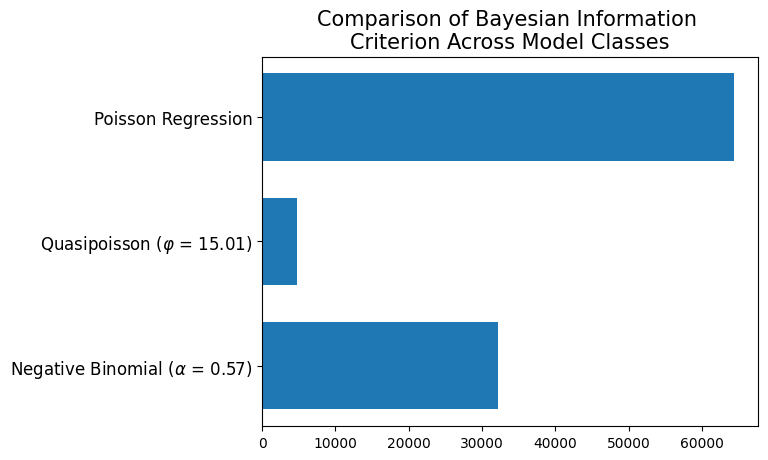

The model with the lowest AIC is best
The model with the lowest BIC is preferred


In [17]:
models = model_selection_df["Model"]
y_values =  np.array([0,1,2])
y_labels = model_selection_df["Model"].values

bic = model_selection_df["BIC"].values[::-1]

fig, ax = plt.subplots()

ax.barh(y = y_values, width = bic, height = .7, label = "AIC")

ax.set_yticks(y_values)
ax.set_yticklabels(y_labels[::-1], fontsize = 12)

plt.title("Comparison of Bayesian Information \nCriterion Across Model Classes", fontsize = 15)
plt.show()

print("The model with the lowest AIC is best")
print("The model with the lowest BIC is preferred")

In [18]:
model_selection_df

,Model,AIC,BIC,RMSE,R2
0,Poisson Regression,64008.692498,64405.984687,17.918314,0.154693
1,Quasipoisson ($\varphi$ = 15.01),4380.662845,4777.955034,17.918314,0.154693
2,Negative Binomial ($\alpha$ = 0.57),31837.346179,32234.638368,17.952462,0.151468


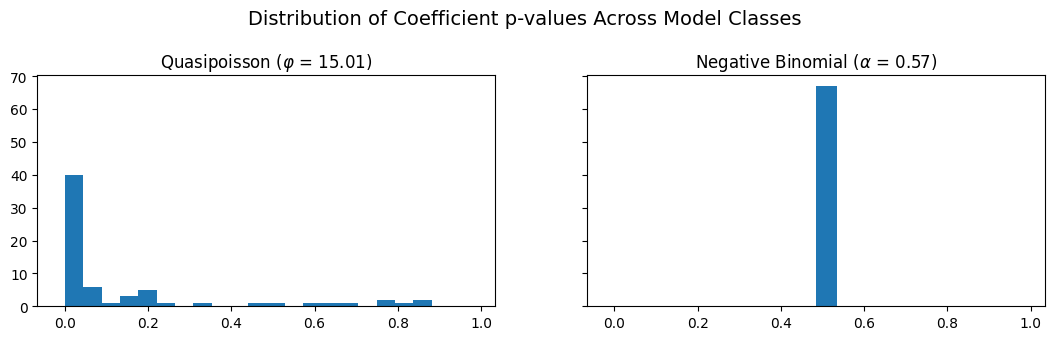

In [19]:
fig, ax = plt.subplots(1,2, figsize = (13,3), sharex = True, sharey = True)
# p_vals = pr_summary_df.loc[:,'P>|z|']
# ax[0].hist(p_vals, bins = 20)
# ax[0].set_title("Poisson Regression")

p_vals = qr_summary_df.loc[:,'P>|z|']
phi = np.around(pr_varphi, decimals = 2)
ax[0].hist(p_vals, bins = 20)
ax[0].set_title(r"Quasipoisson ($\varphi$ = "+f"{phi})")

p_vals = nb_summary_df.loc[:,'P>|z|']
phi = np.around(alpha, decimals = 2)
ax[1].hist(p_vals, bins = 20)
ax[1].set_title(r"Negative Binomial ($\alpha$ = "+f"{phi})")

plt.suptitle("Distribution of Coefficient p-values Across Model Classes", y=1.1, fontsize = 14)
plt.show()

# Model Validation

In [21]:
from sklearn.model_selection import RepeatedKFold
rkf = RepeatedKFold(n_splits=10, n_repeats=100, random_state=42)
i = 0
metrics_dfs = []
coef_dfs = []
pval_dfs = []
conf_dfs = []
for train, test in rkf.split(exog.index):
    exog_train = exog.loc[train,:]
    endog_train = endog[train]

    exog_test = exog.loc[test,:]
    endog_test = endog[test]
    
    nb = sm.GLM(endog_train, exog_train, family = sm.families.NegativeBinomial(alpha = alpha), missing = "drop")
    nb_model = nb.fit()
    y_hat_train = nb_model.predict(exog_train)
    y_bar_train = np.mean(endog_train)
    y_hat_test = nb_model.predict(exog_test)
    y_bar_test = np.mean(endog_test)

    metrics_df = pd.DataFrame()
    coef_df = pd.DataFrame()
    pval_df = pd.DataFrame()
    conf_df = pd.DataFrame()

    metrics_df.loc[i,"BIC"] = nb_model.bic_llf
    metrics_df.loc[i,"RMSE_train"] = (np.sum((y_hat_train - endog_train)**2)/len(endog_train)) ** (1/2)
    metrics_df.loc[i,"RMSE_test"] = (np.sum((y_hat_test - endog_test)**2)/len(endog_test)) ** (1/2)
    metrics_df.loc[i,"R2_train"] = 1 - np.sum((endog_train - y_hat_train) ** 2) / np.sum((endog_train - y_bar_train) ** 2)
    metrics_df.loc[i,"R2_test"] = 1 - np.sum((endog_test - y_hat_test) ** 2) / np.sum((endog_test - y_bar_test) ** 2)
    
    nb_summary = nb_model.summary()
    nb_results_as_html = nb_summary.tables[1].as_html()
    nb_summary_df = pd.read_html(nb_results_as_html, header=0, index_col=0)[0]
    coef_df[i] = nb_summary_df["coef"]
    pval_df[i] = nb_summary_df['P>|z|']
    conf_df[i] = nb_summary_df['std err']
    
    metrics_dfs.append(metrics_df)
    coef_dfs.append(coef_df)
    pval_dfs.append(pval_df)
    conf_dfs.append(conf_df)

    i += 1
    
metric_df = pd.concat(metrics_dfs, axis = 0)
coef_df = pd.concat(coef_dfs, axis = 1)
pval_df = pd.concat(pval_dfs, axis = 1)
conf_df = pd.concat(conf_dfs, axis = 1)

In [ ]:
# metric_df.to_csv("../data/model_summary/metric_df.csv")
# coef_df.to_csv("../data/model_summary/coef_df.csv")
# pval_df.to_csv("../data/model_summary/pval_df.csv")
# conf_df.to_csv("../data/model_summary/conf_df.csv")

In [24]:
metric_df = pd.read_csv("../data/model_summary/metric_df.csv", index_col = 0)
coef_df = pd.read_csv("../data/model_summary/coef_df.csv", index_col = 0)
pval_df = pd.read_csv("../data/model_summary/pval_df.csv", index_col = 0)
conf_df = pd.read_csv("../data/model_summary/conf_df.csv", index_col = 0)

### Evaluate Model Fit

In [25]:
y_hat = np.exp(np.sum(exog.values * nb_summary_df["coef"].values.reshape(1,-1), axis = 1))

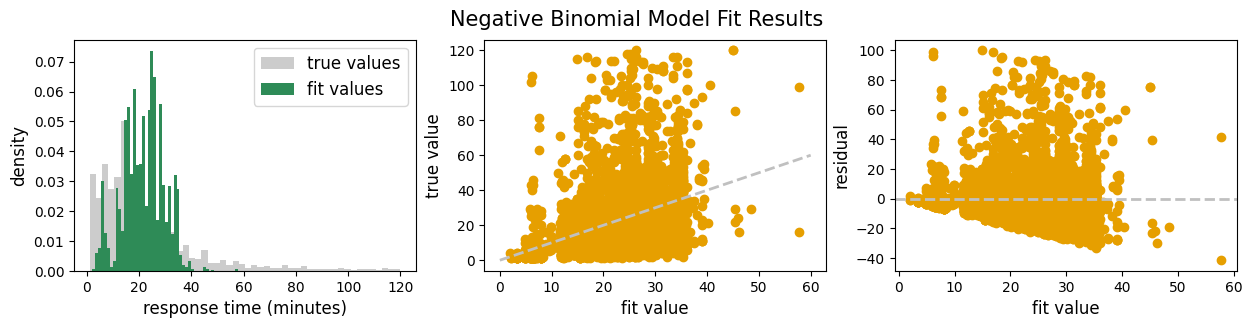

In [26]:
fig, ax = plt.subplots(1,3, figsize = (15,3))
ax[0].hist(endog, color = "silver", alpha = 0.8, density = True, bins = 50, label = "true values")
ax[0].hist(y_hat, color = "seagreen", density = True, bins = 50, label = "fit values")
ax[0].set_xlabel("response time (minutes)", fontsize = 12)
ax[0].set_ylabel("density", fontsize = 12)
ax[0].legend(fontsize = 12)

ax[1].scatter(y_hat, endog, color = COLOR_MAP["light_orange"])
ax[1].plot([0,60],[0,60], linewidth = 2, color = "silver", linestyle = "--")
ax[1].set_xlabel("fit value", fontsize = 12)
ax[1].set_ylabel("true value", fontsize = 12)

ax[2].scatter(y_hat, endog - y_hat, color = COLOR_MAP["light_orange"])
ax[2].axhline(0,linewidth = 2, color = "silver", linestyle = "--")
ax[2].set_xlabel("fit value", fontsize = 12)
ax[2].set_ylabel("residual", fontsize = 12)

plt.suptitle("Negative Binomial Model Fit Results",fontsize = 15)
plt.show()